#### 4. Superfast laser cooling
Trotter cycle:

* Pulse x for dt
$$
H_{X} = \nu a^{\dagger}a + \frac{\Omega_T}{2}[\sigma^{+}D(i\eta) + \sigma^{-}D^{\dagger}(i\eta)]
$$

* Y pulse for pi/2

$$
H_{Y} = \nu a^{\dagger}a + \frac{i\Omega_T}{2}[\sigma^{+}D(i\eta) - \sigma^{-}D^{\dagger}(i\eta)]
$$

* Free evolution
* Undo y pulse
* Disipation

Full sequence:

* Y pi/2 pulse
* Trotter sequence repeated n times
* Undo y pi/2 pulse
* Dissipation

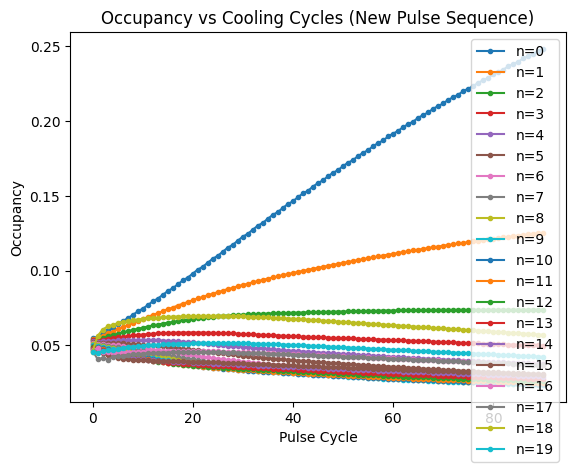

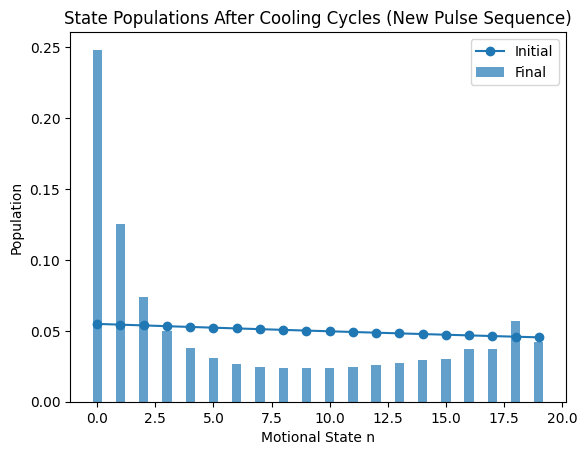

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1  # Detuning
RF_strength = 1  # RF dipolar coupling strength
nu = 1.0     # Motional frequency
eta = 0.31   # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
Omega = nu
n0 = 1
gamma = 5  # Spin relaxation
kT = 100      # Boltzmann constant times temperature
tau =  2*np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space
n_trotter = 10        
Omega_T = 1000  # Boosting Omega to approach Strong Coupling [cite: 10]

dt = 2*np.pi / (5 * eta * Omega_T * np.sqrt(n0))
n_trotter_steps = 180  

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag  # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
s_y = sigmay()
s_x = sigmax()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(s_y, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(s_x, qeye(N))
X_op = a_full + a_dag_full

# Displaced Hamiltonian operator
D_op = tensor(qeye(2), displace(N,1j*eta))

"""Trotter pulse sequence Hamiltonians"""

# 1) X pulse Hamiltonian
H_x = nu * a_dag_full * a_full + 0.5 * Omega_T * (s_plus_full * D_op + s_minus_full * D_op.dag())
L_x = liouvillian(H_x, [])
prop_x = (L_x * dt).expm()

# 3) Y pulse Hamiltonian
H_y = nu * a_dag_full * a_full + 0.5 * Omega_T * (1j * s_plus_full * D_op - 1j * s_minus_full * D_op.dag())
L_y = liouvillian(H_y, [])
prop_y = (L_y * dt).expm()
# Undo Y(π/2)
L_y_undo = liouvillian(-H_y, [])
prop_y_undo = (L_y_undo * dt).expm()

# Free evolution Hamiltonian
H_free = nu * a_dag_full * a_full
L_free = liouvillian(H_free, [])
prop_free = (L_free * 10*dt).expm()

prop_trotter = prop_y_undo * prop_free * prop_x * prop_y

# --- Collapse Operators for Dissipation with recoil ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / np.sum(W)
G = gamma / 2  # This is Γ/2 in the master equation
tg = 2 / G  # Dissipation duration adjusted for rates
c_ops = []
for i, c in enumerate(cosal):
    U_mot = (1j * c * eta * xop).expm()
    U_full = tensor(qeye(2), U_mot)
    c_ops.append(np.sqrt(G * W[i]) * (s_minus_full * U_full))

# Add sigma_minus decay without recoil (optional, for comparison)
c_ops.append(np.sqrt(gamma) * s_minus_full)

# Pumping to ground state propagator
H_diss = nu * a_dag_full * a_full
L_pumping = liouvillian(H_diss, c_ops) 
t_pump = 2.0 / gamma
prop_diss = (L_pumping * t_pump).expm()

# Define pi / 2 Y pulse duration for final step
H_y = nu * a_dag_full * a_full + 0.5 * Omega * (1j * s_plus_full * D_op - 1j * s_minus_full * D_op.dag())
L_y = liouvillian(H_y, [])
prop_y = (L_y * np.pi/2).expm()
# Undo Y(π/2)
L_y_undo = liouvillian(-H_y, [])
prop_y_undo = (L_y_undo * np.pi/2).expm()

# Free evolution Hamiltonian
H_free = nu * a_dag_full * a_full
L_free = liouvillian(H_free, [])
prop_free = (L_free * dt).expm()

prop_cycle = prop_diss * prop_y_undo * (prop_trotter**n_trotter_steps) * prop_y 

# --- Simulation ---
num_pulses = 90  # Number of cycles
times_sim = np.arange(num_pulses + 1)  # Integer steps for cycles

# Initial state: spin in ground, motion thermal
thermal_state = (- nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()
ground_state = basis(2, 1)
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies_fast = np.zeros((num_pulses + 1, N))
rho_current = operator_to_vector(initial_state)


# Initial occupancy
occupancies_fast[0, :] = initial_state.ptrace(1).diag().real

# Evolve step-by-step under the new pulse sequence
for k in range(1, num_pulses + 1):
    rho_current = prop_cycle * rho_current
    
    # Store data
    rho_mat = vector_to_operator(rho_current)
    occupancies_fast[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies_fast[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies_fast[0, :]
p_motional_final = occupancies_fast[-1, :]
plt.figure()
plt.plot(np.arange(N), p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N), p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles (New Pulse Sequence)')
plt.legend()
plt.show()